# Goodreads stats
Plots average daily pages read for each book in my goodreads library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import requests

In [3]:
from configparser import ConfigParser

In [5]:
config = ConfigParser()
config.read('config.ini')

client_id = config.get('Identity', 'id')
key = config.get('Identity', 'key')

## API call: Get the books on a members shelf
Get the books on a members shelf. Customize the feed with the below variables. Viewing members with profiles who have set them as visible to members only or just their friends requires using OAuth.
* URL: https://www.goodreads.com/review/list?v=2
* HTTP method: GET
* Parameters:
    * v: 2
    * id: Goodreads id of the user
    * shelf: read, currently-reading, to-read, etc. (optional)
    * sort: title, author, cover, rating, year_pub, date_pub, date_pub_edition, date_started, date_read, date_updated, date_added, recommender, avg_rating, num_ratings, review, read_count, votes, random, comments, notes, isbn, isbn13, asin, num_pages, format, position, shelves, owned, date_purchased, purchase_location, condition (optional)
    * search[query]: query text to match against member's books (optional)
    * order: a, d (optional)
    * page: 1-N (optional)
    * per_page: 1-200 (optional)
    * key: Developer key (required).

In [6]:
payload = {'key':key, 'id':client_id, 'shelf':'read', 'sort':'date_started', 'per_page':200}
r = requests.get('https://www.goodreads.com/review/list?v=2', params=payload)

In [7]:
import xml.etree.ElementTree as ET

In [8]:
root = ET.fromstring(r.content)

In [9]:
import pandas as pd

In [10]:
def entry_generator(root):
    for review in root.iter('review'):
        book =  review.find('book')
        title = book.find('title').text
        started_at = review.find('started_at').text
        read_at = review.find('read_at').text
        num_pages = book.find('num_pages').text
        yield title, pd.to_numeric(num_pages), pd.to_datetime(started_at), pd.to_datetime(read_at)

In [11]:
df = pd.DataFrame(data=entry_generator(root), columns=['title', 'num_pages', 'started_at', 'finished_at'])
df.dropna(inplace=True)
df['interval'] = df.finished_at - df.started_at
df['interval_hours'] = df.interval.dt.seconds/3600 + df.interval.dt.days*24
df['pages_per_day'] = df.num_pages/df.interval_hours*24
df.head()

,title,num_pages,started_at,finished_at,interval,interval_hours,pages_per_day
0,"The Fall of Hyperion (Hyperion Cantos, #2)",517.0,2018-05-09 11:09:07,2018-06-13 00:58:14,34 days 13:49:07,829.818611,14.952665
1,"Hyperion (Hyperion Cantos, #1)",482.0,2018-04-27 08:01:44,2018-05-09 11:08:09,12 days 03:06:25,291.106944,39.737973
2,Galápagos,324.0,2018-04-18 12:41:22,2018-04-25 14:43:32,7 days 02:02:10,170.036111,45.731462
3,"Inversions (Culture, #6)",343.0,2018-04-03 07:57:17,2018-04-17 09:43:20,14 days 01:46:03,337.767500,24.371794
4,"Dark Alliance: The CIA, the Contras, and the C...",592.0,2018-03-09 11:07:29,2018-03-30 16:11:37,21 days 05:04:08,509.068889,27.909779


### Number of pages in each book

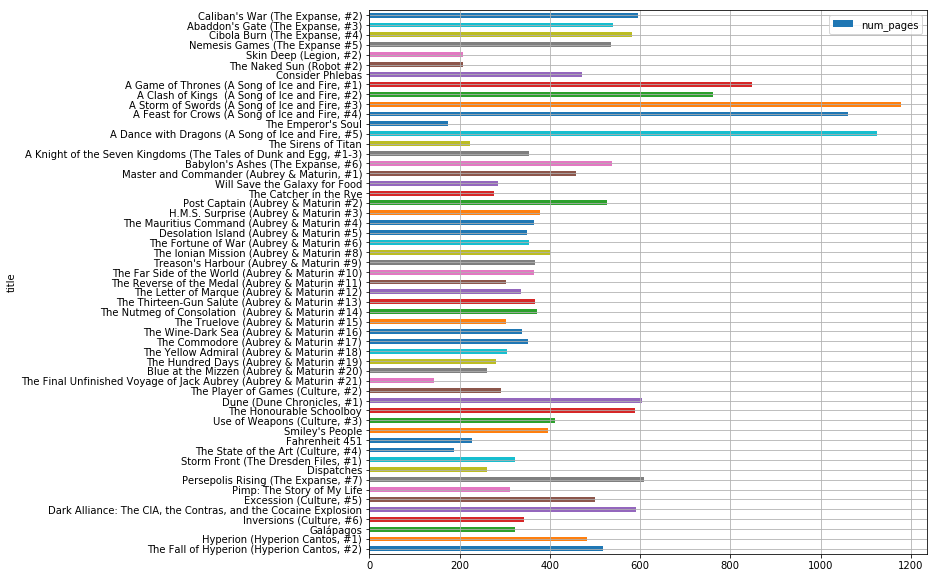

In [12]:
df.plot.barh(x='title', y='num_pages', figsize=(10, 10), grid=True)

### Total number of hours before book was logged as *read*
The strong outlier is *Dispatches* which I've only resumed reading and finished after a long hiatus

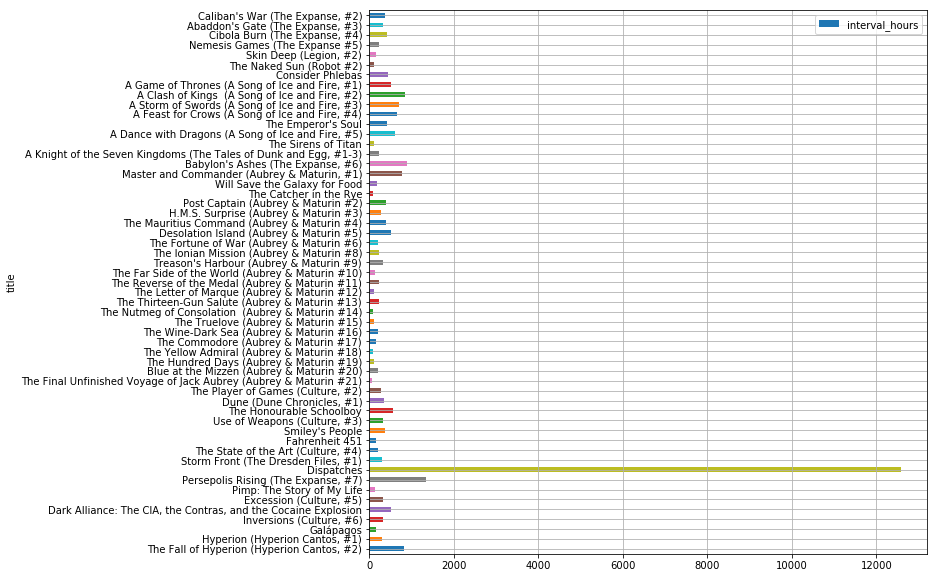

In [13]:
df.plot.barh(x='title', y='interval_hours', figsize=(10, 10), grid=True)

### Number of hours vs Number of pages
The outlier is *Dispatches* again

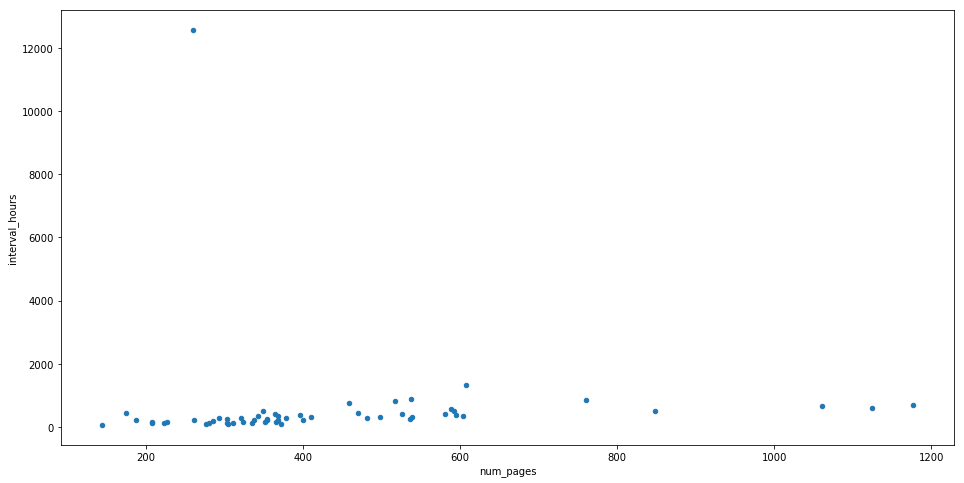

In [14]:
df.plot.scatter(x='num_pages', y='interval_hours', figsize=(16, 8))

### Bar plot of number of pages vs number of number of hours
Bar width indicates number of hours before the book was logged as *read*

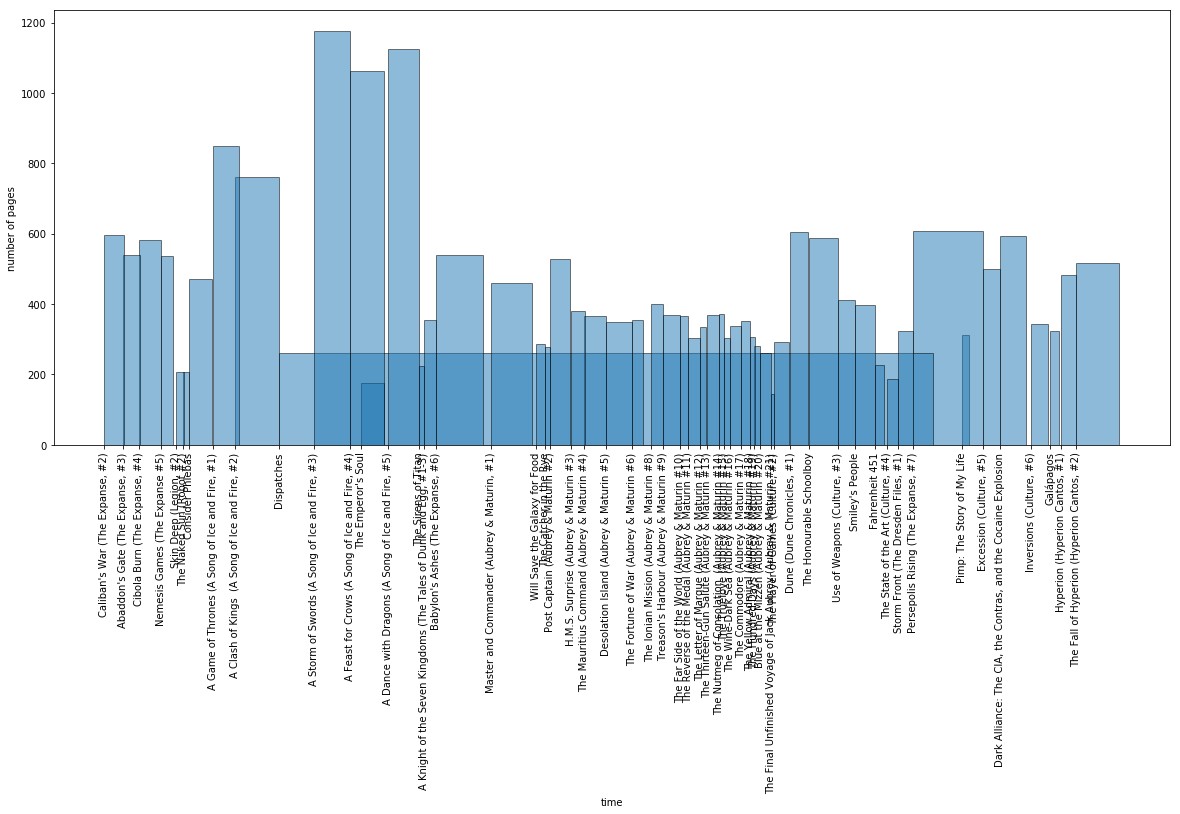

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
width = df.interval.view('int64').values
started_at = df.started_at.view('int64').values

ax.bar(started_at, df.num_pages.values, width=width, tick_label=df.index, align='edge', linewidth=1, edgecolor='k', alpha=0.5)
ax.set_xticklabels(df.title, rotation='vertical')
ax.set_xlabel('time')
ax.set_ylabel('number of pages')
pass

### Bar plot of average number of pages per day

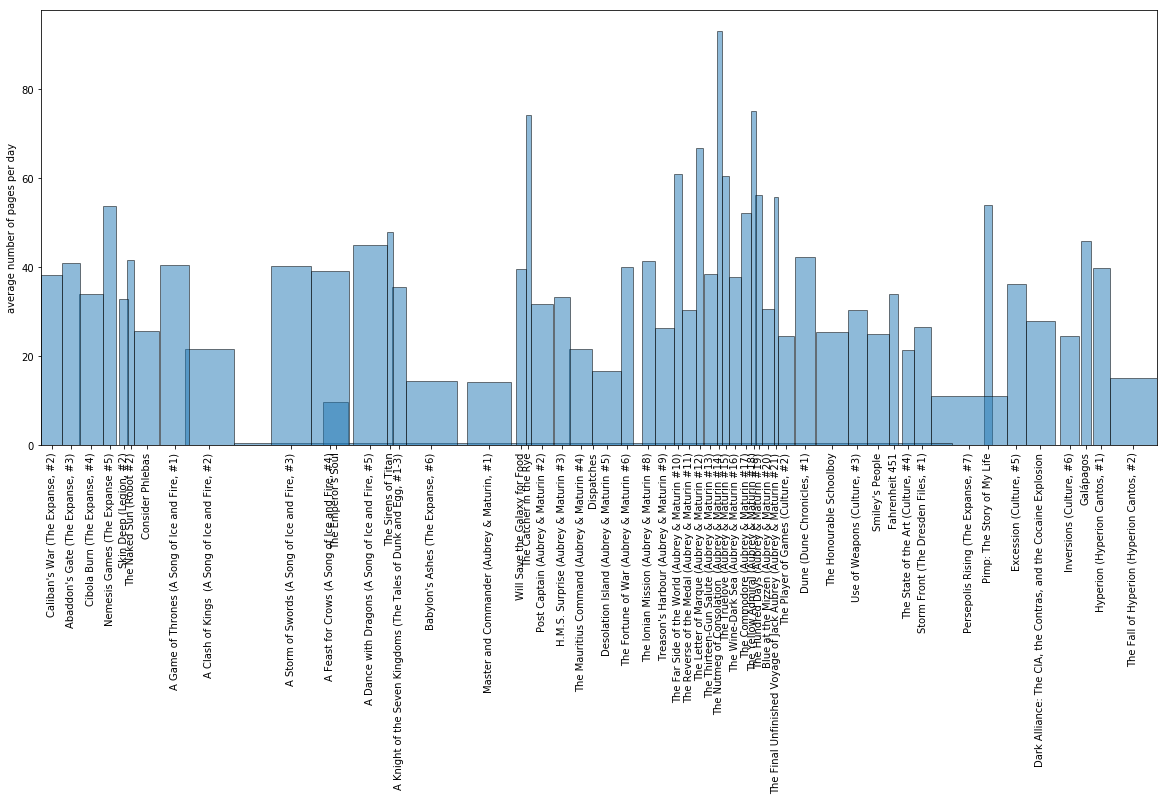

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))
width = df.interval.view('int64').values
started_at = df.started_at.view('int64').values
center = started_at + width/2

ax.bar(center, df.pages_per_day.values, width=width, tick_label=df.index, align='center', linewidth=1, edgecolor='k', alpha=0.5)
ax.set_xticklabels(df.title, rotation='vertical')
ax.set_xlim(min(started_at), max(started_at + width))
ax.set_ylabel('average number of pages per day')
pass

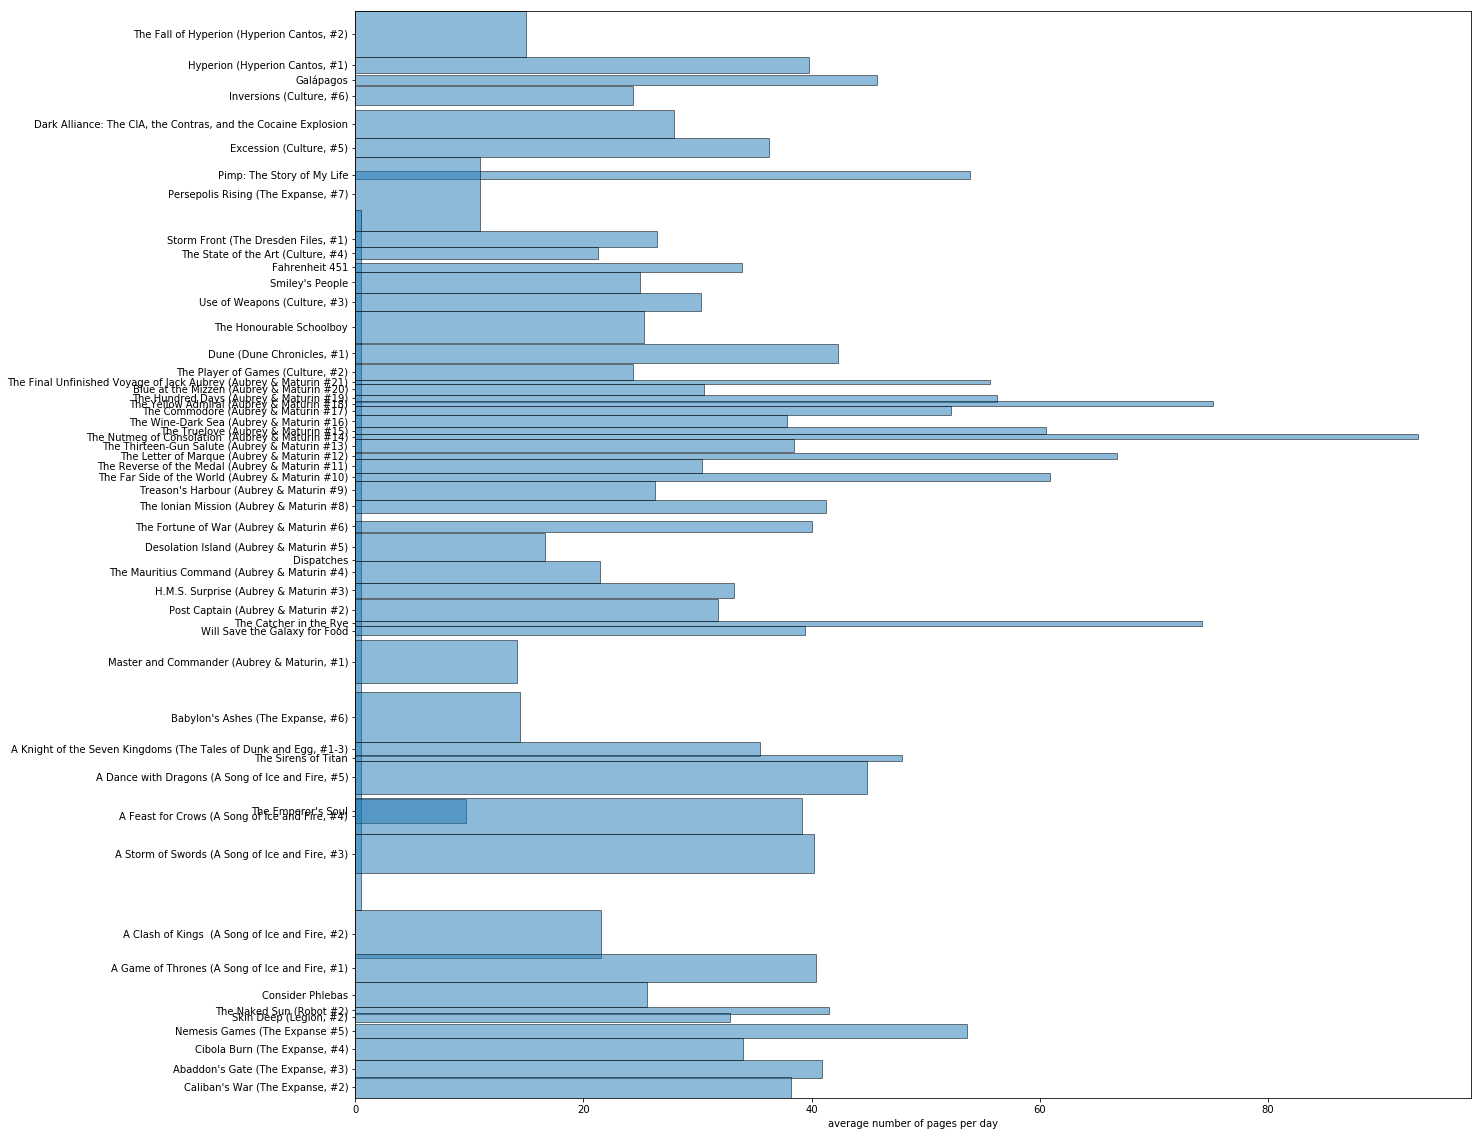

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
height = df.interval.view('int64').values
started_at = df.started_at.view('int64').values
center = started_at + height/2

ax.barh(center, df.pages_per_day.values, height=height, tick_label=df.index, align='center', linewidth=1, edgecolor='k', alpha=0.5)
ax.set_yticklabels(df.title)
ax.set_ylim(min(started_at), max(started_at + width))
ax.set_xlabel('average number of pages per day')
pass